In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
test = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [3]:
print(train.shape, test.shape)

(4209, 378) (4209, 377)


## Encode

In [4]:
cols_cat = train.select_dtypes(include = ['object']).columns.values
cols_cat = cols_cat.tolist()
cols_bin = train.select_dtypes(include = ['int64']).columns.values
cols_bin = cols_bin[cols_bin != "ID"].tolist()

In [5]:
for c in cols_cat:
    x = list(set(list(train[c].values) + list(test[c].values))) 
    x.sort()
    x.sort(key = len)
    dt_labelEncode_c = pd.DataFrame({"Encode_Label_" + c: [i for i in range(1, (len(x) + 1))]
                                     , c: x})

    train = pd.merge(train, dt_labelEncode_c, on = c)
    test = pd.merge(test, dt_labelEncode_c, on = c)

## TargetMean

In [6]:
def getTargetMean(dt_train, dt_test, cols, k = 3, random_state = 888):

    if k == 1:
        train_cp = dt_train.copy()
        test_cp = dt_test.copy()
        for c in cols:
            x = train_cp.groupby([c])["y"].mean()
            dt_targetMean_c = pd.DataFrame({c: x.index
                                           , "Encode_TargetMean_" + c: x.values})
            train_cp = pd.merge(dt_targetMean_c, train_cp, on = c)

            test_cp = pd.merge(dt_targetMean_c, test_cp, on = c, how = "right")
            test_cp = test_cp.fillna(np.mean(train_cp.y))

        return train_cp, test_cp
    else:
        for col in cols:
            X_train_fold = pd.DataFrame()
            X_test_fold = pd.DataFrame()

            skf = StratifiedKFold(n_splits = k, random_state = random_state)

            for i, (ind_in, ind_out) in enumerate(skf.split(dt_train, dt_train[col].values)):
                X_in, X_out = dt_train.iloc[ind_in], dt_train.iloc[ind_out]
                # targetMean in
                dt_targetMean_fold = pd.DataFrame({col: X_in.groupby([col])["y"].mean().index
                                                  , "Encode_TargetMean_" + col: X_in.groupby([col])["y"].mean()})
                # merge targetMean out
                X_out_fold = pd.merge(X_out, dt_targetMean_fold, on = col, how = "left")
                X_out_fold = X_out_fold.fillna(np.mean(X_in.y))

                # concat X_out_fold
                X_train_fold = pd.concat([X_train_fold, X_out_fold])

                # merge with test
                dt_targetMean_fold = dt_targetMean_fold.rename(columns = {"Encode_TargetMean_" + col: "Encode_TargetMean_fold_" + col + "_" + str(i)})
                if i == 0:
                    X_test_fold = pd.merge(dt_test, dt_targetMean_fold, on = col, how = "left")
                else:
                    X_test_fold = pd.merge(X_test_fold, dt_targetMean_fold, on = col, how = "left")

                # mean for test
                cols_encode_fold = X_test_fold.filter(regex = "Encode_TargetMean_fold_").columns.values
                X_test_fold["Encode_TargetMean_" + col] = X_test_fold[cols_encode_fold].mean(axis = 1)
                X_test_fold = X_test_fold.drop(cols_encode_fold, axis = 1)
                X_test_fold = X_test_fold.fillna(np.mean(X_in.y))
    
    return X_train_fold, X_test_fold 


In [7]:
train, test = getTargetMean(train, test, cols_cat, 1)

In [8]:
cols_targetMean = train.filter(regex = "Encode_TargetMean_").columns.values.tolist()

In [9]:
print(train.shape, test.shape)

(4209, 394) (4209, 393)


## OutlierMaker

In [10]:
def getOutlierMarker(dt_train, dt_test, perc = 100):
    
    dt_train_cp = dt_train.copy()
    dt_test_cp = dt_test.copy()
    
    # outlier
    bin_y = pd.qcut(dt_train_cp.y.values, perc, labels = [i for i in range(1, perc + 1)]).astype("int64")
    dt_outliers = dt_train_cp.iloc[bin_y == perc]
    
    cols_types = ["Cat", "Bin", "All", "X0", "X5"]
    for cols_type in cols_types:
        if cols_type == "Cat":
            cols = cols_cat
        elif cols_type == "Bin":
            cols = cols_bin
        elif cols_type == "All":
            cols = cols_cat + cols_bin
        else:
            cols = [cols_type]
            
        # calc int_outlierMarker_train, int_outlierMarker_test
        int_outlierMarker_train = np.zeros(dt_train_cp.shape[0])
        int_outlierMarker_test = np.zeros(dt_test_cp.shape[0])
        for i in range(1, dt_outliers.shape[0] + 1):
            dt_outliers_i = dt_outliers.iloc[(i - 1):i, :][cols]

            # calc int_outlierMarker_train_i
            int_outlierMarker_train_i = np.zeros(dt_train_cp.shape[0])
            for col in dt_outliers_i.columns.values:
                for val in dt_outliers_i[col].values:
                    int_outlierMarker_train_i += (dt_train_cp[col].values == val).astype("int64")
            # calc int_outlierMarker_test_i
            int_outlierMarker_test_i = np.zeros(dt_test_cp.shape[0])
            for col in dt_outliers_i.columns.values:
                for val in dt_outliers_i[col].values:
                    int_outlierMarker_test_i += (dt_test_cp[col].values == val).astype("int64")

            int_outlierMarker_train += int_outlierMarker_train_i
            int_outlierMarker_test += int_outlierMarker_test_i
    
        # add as column
        dt_train_cp.loc[:, "FeatEng_OutlierMaker_" + cols_type] = int_outlierMarker_train
        dt_test_cp.loc[:, "FeatEng_OutlierMaker_" + cols_type] = int_outlierMarker_test
        
    return dt_train_cp, dt_test_cp

## Dimension Reduce

In [11]:
# standardize
train_norm = StandardScaler().fit_transform(train.drop(["y"] + cols_cat + cols_targetMean, axis=1))
test_norm = StandardScaler().fit_transform(test.drop(cols_cat + cols_targetMean, axis = 1))

In [12]:
n_comp = 12
n_comp_pca = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train_norm)
tsvd_results_test = tsvd.transform(test_norm)

# PCA
pca = PCA(n_components=n_comp_pca, random_state=420)
pca2_results_train = pca.fit_transform(train_norm)
pca2_results_test = pca.transform(test_norm)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train_norm)
ica2_results_test = ica.transform(test_norm)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train_norm)
grp_results_test = grp.transform(test_norm)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train_norm)
srp_results_test = srp.transform(test_norm)


In [13]:
# Append decomposition components to datasets
for i in range(1, n_comp + 1):

    train['ICA_' + str(i)] = ica2_results_train[:, i - 1]
    test['ICA_' + str(i)] = ica2_results_test[:, i - 1]

    train['TSVD_' + str(i)] = tsvd_results_train[:, i - 1]
    test['TSVD_' + str(i)] = tsvd_results_test[:, i - 1]

    train['GRP_' + str(i)] = grp_results_train[:, i - 1]
    test['GRP_' + str(i)] = grp_results_test[:, i - 1]

    train['SRP_' + str(i)] = srp_results_train[:, i - 1]
    test['SRP_' + str(i)] = srp_results_test[:, i - 1]

In [14]:
for i in range(1, n_comp_pca + 1):
    
    train['PCA_' + str(i)] = pca2_results_train[:, i - 1]
    test['PCA_' + str(i)] = pca2_results_test[:, i - 1]

In [15]:
print(train.shape, test.shape)

(4209, 454) (4209, 453)


## xgboost

In [16]:
# r_2 for xgboost
def r_2(preds, dtrain):
    labels = dtrain.get_label()
    return 'score', r2_score(labels, preds)

In [17]:
# y_train_all
y_train_all = train.y.values

In [18]:
k = 8
# bin
bin_y = pd.qcut(y_train_all, k, labels = [i for i in range(1, k + 1)]).astype("int64")
# stratified kfold
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 888)

score_skf_valid = 0
score_skf = []
preds_skf_test = []
dt_preds_test = []
for i, (ind_train, ind_valid) in enumerate(skf.split(train, bin_y)):
    # X, y
    X_train, X_valid = train.iloc[ind_train], train.iloc[ind_valid]
    
    # featEng: TargetMean, Outlier
    ## train, valid
#     X_train_transform, X_valid_transform = getTargetMean(X_train, X_valid, cols_cat, 1) # targetMean
#     X_train_transform, X_valid_transform = getOutlierMarker(X_train_transform, X_valid_transform, 600) # outlierMaker
#     y_train_transform, y_valid_transform = X_train_transform.y.values, X_valid_transform.y.values
#     X_train_transform, X_valid_transform = X_train_transform.drop(["y"] + cols_cat, axis = 1), X_valid_transform.drop(["y"] + cols_cat, axis = 1)
    y_train_transform, y_valid_transform = X_train.y.values, X_valid.y.values
    X_train_transform, X_valid_transform = X_train.drop(["y"] + cols_cat, axis = 1), X_valid.drop(["y"] + cols_cat, axis = 1)
    
    ## test
#     _, X_test_transform = getTargetMean(X_train, test, cols_cat, 1) # targetMean
#     _, X_test_transform = getOutlierMarker(X_train, X_test_transform, 600) # outlierMaker
#     X_test_transform = X_test_transform.drop(cols_cat, axis = 1)
    X_test_transform = test.drop(cols_cat, axis = 1)
    
    # xgb.DMatrix
    dmx_train = xgb.DMatrix(X_train_transform, label = y_train_transform)
    dmx_valid = xgb.DMatrix(X_valid_transform, label = y_valid_transform)
    dmx_test = xgb.DMatrix(X_test_transform)
    ls_watch =  [(dmx_train, 'train'), (dmx_valid, 'eval')]
    
    # params
    params_xgb = {
        "objective": "reg:linear"
        , "booster": "gbtree"
        , "learning_rate": 0.005
        , "subsample": .9
        , "colsample": .8
        , "max_depth": 2
        , "alpha": 1
        , "lambda": 2
        , "gamma": 20
        , "base_score": np.mean(y_train_transform)
    }
    
    # model
    model_xgb = xgb.train(params_xgb, dmx_train, evals = ls_watch
                          , num_boost_round = 5000
                          , feval = r_2, maximize = True, early_stopping_rounds = 50
                          , verbose_eval = False
                         )
    
    # predict
    preds_valid = model_xgb.predict(dmx_valid)
    preds_test = model_xgb.predict(dmx_test)
    preds_skf_test.append(preds_test)
    dt_preds_test.append(pd.DataFrame({"ID": X_test_transform.ID
                                      , "preds_y_" + str(i): preds_test}))
    # score
    score_skf_valid = r2_score(y_valid_transform, preds_valid)
    print('Fold %d: Score %f'%(i, score_skf_valid))
    score_skf.append(score_skf_valid)

# predict test
preds_test = np.sum(np.transpose(np.multiply(np.transpose(np.array(preds_skf_test)), np.array(score_skf))), axis = 0) / np.sum(score_skf)
# final score
score_mean = np.mean(score_skf)
score_sd = np.std(score_skf)
print('=====================')

print('Final Score %f'%score_mean, '; sd %f'%score_sd)

print('=====================')

Fold 0: Score 0.547304
Fold 1: Score 0.547475
Fold 2: Score 0.631751
Fold 3: Score 0.638154
Fold 4: Score 0.558286
Fold 5: Score 0.639817
Fold 6: Score 0.632201
Fold 7: Score 0.451394
Final Score 0.580798 ; sd 0.062745


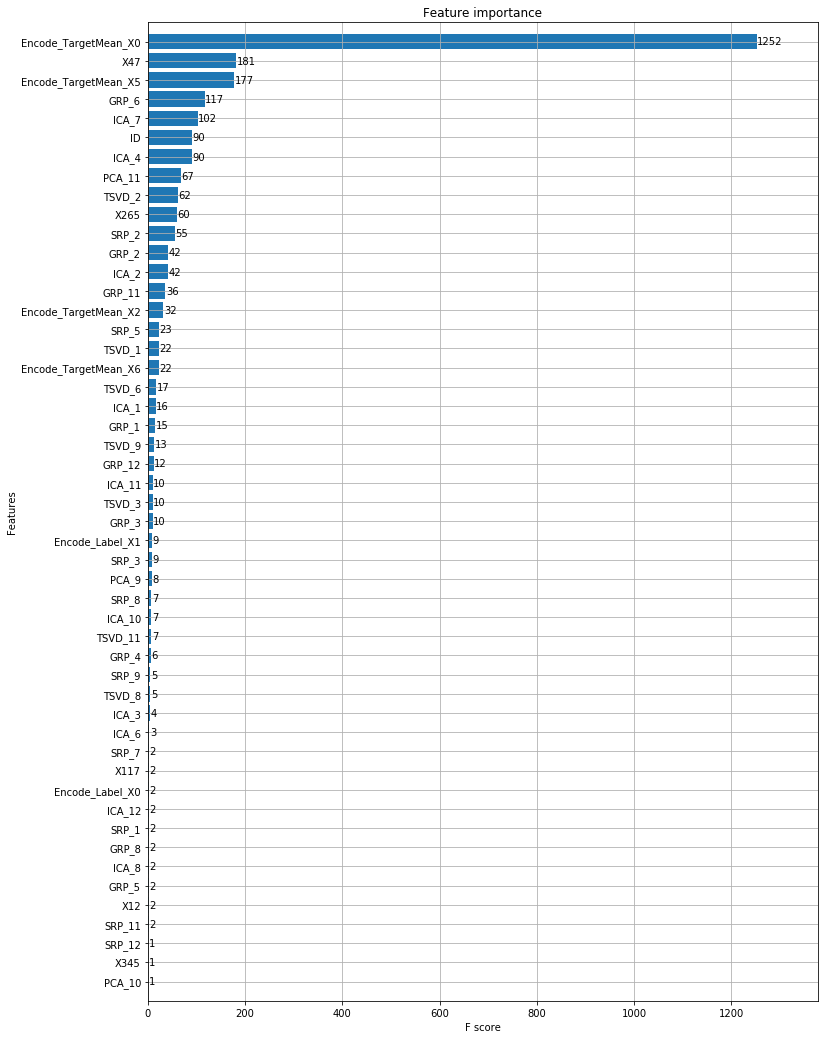

In [19]:
# importance
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model_xgb, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

In [20]:
preds_test

array([  94.76704422,  103.88008742,  104.38572259, ...,  103.96147642,
        103.17903732,  102.96808201])

In [21]:
dt_preds_test[3].head()

,ID,preds_y_3
0,1228,94.846069
1,4342,103.921638
2,5299,104.171570
3,6774,93.927887
4,7631,101.698326


In [22]:
# submit
dt_submit = pd.DataFrame({"ID": dt_preds_test[0].ID
            , "y": preds_test})

In [24]:
dt_submit.to_csv("../../data/Mercedes_Benz_Greener_Manufacturing/submission/35_returnToPython_skf8_weightedPrediction_base_features_withTargetMeanFullOutsideSkf_12DR.csv", index = False)